# Dataset Analysis

The Pfam dataset was introduced in the publication - "Using deep learning to annotate the protein universe". [Link to publication](https://www.nature.com/articles/s41587-021-01179-w)

Data Source: [Kaggle Datasets](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split)

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set the style of plots
sns.set_theme(style="whitegrid")

In [3]:
# Colab - connect Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/colabProteinProject/src/protein_universe_annotate')

In [5]:
from data_processing import read_pfam_dataset
from data_exploration import is_bijection_mapping, compute_overlap,\
    detect_outliers_zscore, plot_sequence_len_dist, get_amino_acid_freq, plot_code_freq,\
    plot_class_percentage_distribution_line, plot_class_distribution_line, plot_class_distribution_hist,\
    get_partitions_info

In [6]:
# Data folder containing all the data partitions
data_partitions_dirpath = '/content/drive/MyDrive/colabProteinProject/data/random_split'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev', 'test', 'train']


In [7]:
# Read each dataset partition into a pandas DataFrame
partition_names = ['train', 'dev', 'test']
partition_frames = [read_pfam_dataset(dir_name, data_partitions_dirpath) for dir_name in partition_names]

In [8]:
# Take a look into what the data is looking like in the data frame
partition_frames[0].head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...
4,Mycobact_memb,MMPS4_MYCLE/16-154,PF05423.13,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...


In [9]:
# Assign the dataset type to each sample by adding a new 'split' column
for split_name, data_df in zip(partition_names, partition_frames):
    data_df['split_name'] = split_name

In [10]:
# Convert true labels from PF00001.21 to PF00001
for data_df in partition_frames:
    data_df['true_label'] = data_df.family_accession.apply(lambda s: s.split('.')[0])

In [11]:
# Extract length of sequence
for data_df in partition_frames:
    data_df['sequence_len'] = data_df['sequence'].apply(lambda x: len(x))

In [12]:
# Named references train, dev, and test sets for the respective partitions
train_df, dev_df, test_df = partition_frames

In [13]:
# Concatenate the datasets in one DataFrame
total_data_df = pd.concat([test_df, dev_df, train_df], ignore_index=True)

In [14]:
# Collect basic statistics about the partitions in a data sets to compare them
get_partitions_info(partition_frames, partition_names)

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,train,1086741,17929,3637,1,4,2037,155.379971
1,dev,126171,13071,454,1,9,1971,154.222206
2,test,126171,13071,454,1,9,1937,154.166845


In [15]:
# Basic info
print(f"Number of samples from dev-test-train: {total_data_df.shape[0]}")
print(f"Number of features: {total_data_df.shape[1]}")
print(f"Features: {total_data_df.columns.tolist()}")

Number of samples from dev-test-train: 1339083
Number of features: 8
Features: ['family_id', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence', 'split_name', 'true_label', 'sequence_len']


**Observations**:

- The provided dataset is split into a train-dev-test sets with an approximate ration 80% - 10% - 10%.
- 4858 target classes are only represented in the training partition.

In [16]:
# Check for missing values in each column
print('Missing values in dataset: \n', total_data_df.isnull().sum())

Missing values in dataset: 
 family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
split_name          0
true_label          0
sequence_len        0
dtype: int64


In [17]:
# Checking for duplicates on the sample level
print(f'Duplicated entries in dataset: {total_data_df.duplicated().any()}')

Duplicated entries in dataset: False


In [18]:
# Check for duplicates on 'sequence' level in each dataset split
for split_name, data_df in zip(partition_names, partition_frames):
    seq_duplicates = data_df[data_df.duplicated(subset=['sequence'], keep='first')]
    print(f'Num. duplicates in #{split_name}: {seq_duplicates.shape[0]}')

Num. duplicates in #train: 426
Num. duplicates in #dev: 21
Num. duplicates in #test: 10


In [19]:
# Does the target label like PF00001 have multiple versions (e.g. PF00001.12, PF00001.27)?
print('The target variable \'family_accession\' contains only unique mapping to its version: {}'.
        format(is_bijection_mapping(total_data_df, col1='true_label', col2='family_accession')))

The target variable 'family_accession' contains only unique mapping to its version: True


In [20]:
# Does the 'family_id' and 'true_label' have 1:1 mapping?
print('The \'family_id\' feature contains only unique mapping to true_label feature: {}'.
        format(is_bijection_mapping(total_data_df, col1='family_id', col2='true_label')))

The 'family_id' feature contains only unique mapping to true_label feature: True


**Observations**: 
- Family_id has a unique mapping to family_accession. Both variables could be target class to predict. To be consistent with the original publication, family_accession (without version) is used as a target class to predict. 
- The target variable 'family_accession' contains only unique mapping to its version.

In [21]:
num_distinct_labels = total_data_df['true_label'].nunique()
print(f"There are {num_distinct_labels} distinct values in the 'true_label' column.")

There are 17929 distinct values in the 'true_label' column.


In [22]:
print('Number of unique classes in Train: ', train_df['true_label'].nunique())
print('Number of unique classes in Test: ', test_df['true_label'].nunique())
print('Number of unique classes in Dev: ', dev_df['true_label'].nunique())

Number of unique classes in Train:  17929
Number of unique classes in Test:  13071
Number of unique classes in Dev:  13071


In [23]:
# Are there overlaps between sets in 'true_label'?
overlapping_vals = compute_overlap(train_df, test_df, 'true_label')
print(f'Number of overlapping labels Train -- Test: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(train_df, dev_df, 'true_label')
print(f'Number of overlapping labels Train -- Dev: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(dev_df, test_df, 'true_label')
print(f'Number of overlapping labels Dev -- Test: {len(overlapping_vals)}')

Number of overlapping labels Train -- Test: 13071
Number of overlapping labels Train -- Dev: 13071
Number of overlapping labels Dev -- Test: 13071


**Observations**:
- All true labels (to be predicted) from test and dev dataset are included in the training dataset.

In [24]:
# Are there overlaps between sets in 'sequence'?
overlapping_vals = compute_overlap(train_df, test_df, 'sequence')
print(f'Number of overlapping sequences Train -- Test: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(train_df, dev_df, 'sequence')
print(f'Number of overlapping sequences Train -- Dev: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(test_df, dev_df, 'sequence')
print(f'Number of overlapping sequences Test -- Dev: {len(overlapping_vals)}')

Number of overlapping sequences Train -- Test: 60
Number of overlapping sequences Train -- Dev: 67
Number of overlapping sequences Test -- Dev: 18


**Observations**: 
- Overlap less than 0.01% so all good! The number of overlapping sequences (input to ML models) is too low to have any negative impact, so can be ignored at the moment. Alternatively, overlapping sequences between sets could be removed.

### Domain sequence length

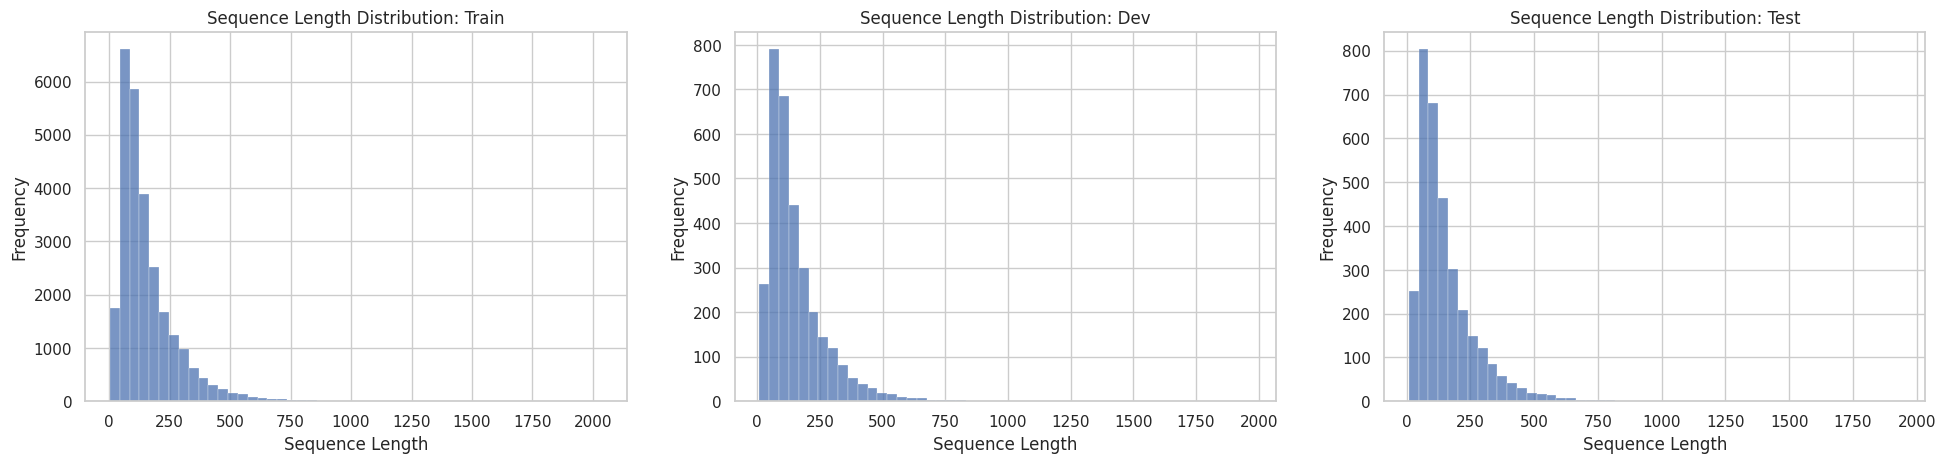

In [25]:
plt.subplot(1, 3, 1)
plot_sequence_len_dist(train_df, 'Train')

plt.subplot(1, 3, 2)
plot_sequence_len_dist(dev_df, 'Dev')

plt.subplot(1, 3, 3)
plot_sequence_len_dist(test_df, 'Test')

plt.subplots_adjust(right=3.0)
plt.savefig('sequence_len_dist.png', dpi=300, bbox_inches='tight')
plt.show()

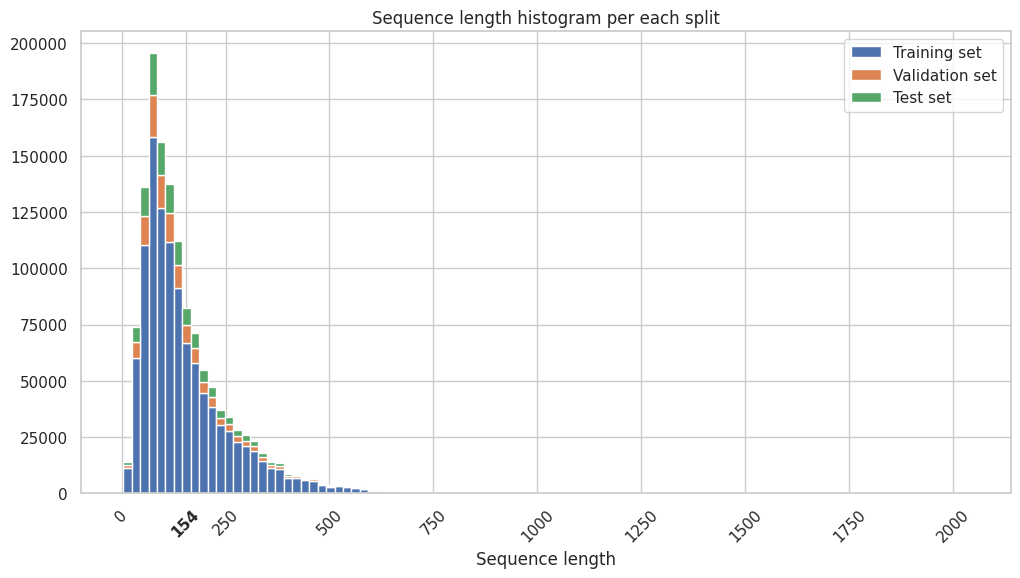

In [26]:
# Plot a stacked histogram for the three partitions 
# Notice the average sequence length being highlighted in the visualization

plt.figure(figsize=(12, 6))

plt.hist(
    [data_df.sequence_len for data_df in partition_frames], 
    stacked=True, 
    bins=100
)

plt.legend([
    f'{name} set' for name in ('Training', 'Validation', 'Test')
])

plt.xlabel('Sequence length')

plt.xticks(
    ticks=list(range(0, 2001, 250)) + [154],
    labels=list(range(0, 2001, 250)) + [154],
    rotation=45
)

plt.title('Sequence length histogram per each split')
plt.xticks()[1][-1].set_fontweight('bold')
plt.show()

In [27]:
dev_df.sequence_len.describe()

count    126171.000000
mean        154.222206
std         118.278250
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1971.000000
Name: sequence_len, dtype: float64

In [28]:
test_df.sequence_len.describe()

count    126171.000000
mean        154.166845
std         118.376706
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1937.000000
Name: sequence_len, dtype: float64

In [29]:
train_df.sequence_len.describe()

count    1.086741e+06
mean     1.553800e+02
std      1.201232e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence_len, dtype: float64

**Observations**: 
- Most of the input sequences have length in range \[15-300\] amino-acids per sequence.


Zoom into the rare sequence lengths starting by sequences longer than 500 residues (amino acids).

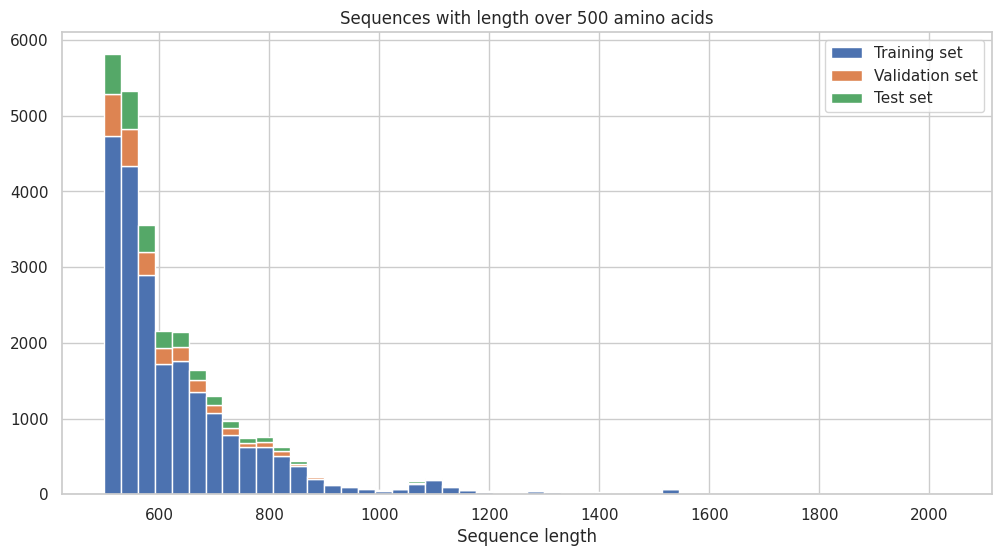

In [30]:
plt.figure(figsize=(12, 6))

plt.hist(
    [data_df[data_df.sequence_len >= 500].sequence_len for data_df in partition_frames], 
    stacked=True, 
    bins=50
)

plt.legend([
    f'{name} set' for name in ('Training', 'Validation', 'Test')
])

plt.title('Sequences with length over 500 amino acids')
plt.xlabel('Sequence length')
plt.show()

**Observations**:

- Long sequences of 800+ amino-acids are way under-represented in the Pfam dataset. 

#### Check the sequences shorter than 50 residues in length.

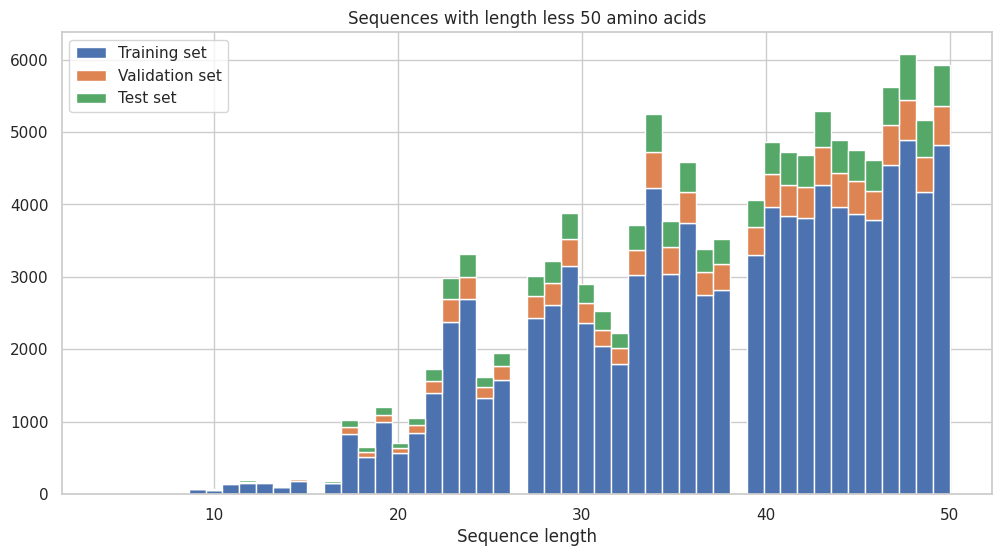

In [31]:
plt.figure(figsize=(12, 6))

plt.hist(
    [data_df[data_df.sequence_len <= 50].sequence_len for data_df in partition_frames], 
    stacked=True, 
    bins=50
)

plt.legend([
    f'{name} set' for name in ('Training', 'Validation', 'Test')
])

plt.title('Sequences with length less 50 amino acids')
plt.xlabel('Sequence length')
plt.show()

**Observations**:
- Short sequences of less than 15 amino-acids are also under-represented in this dataset.

<Axes: xlabel='sequence_len'>

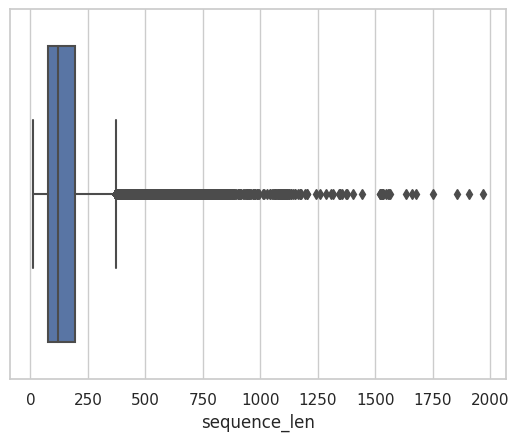

In [ ]:
sns.boxplot(x=dev_df['sequence_len'])

<Axes: xlabel='sequence_len'>

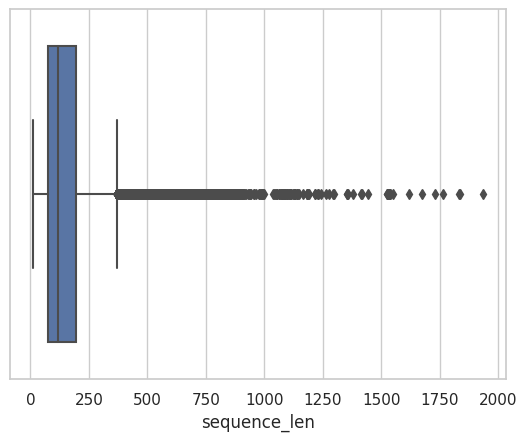

In [ ]:
sns.boxplot(x=test_df['sequence_len'])

<Axes: xlabel='sequence_len'>

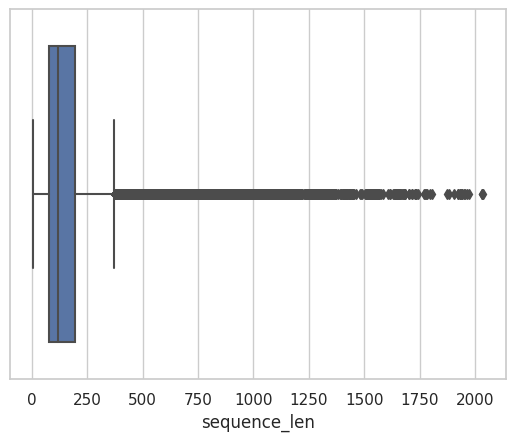

In [ ]:
sns.boxplot(x=train_df['sequence_len'])

In [ ]:
dev_outliers = detect_outliers_zscore(dev_df, 'sequence_len')
test_outliers = detect_outliers_zscore(test_df, 'sequence_len')
train_outliers = detect_outliers_zscore(train_df, 'sequence_len')

In [ ]:
print(f'Num. significantly longer sequences in Dev: {(len(dev_outliers) / len(dev_df)) * 100} %')
print(f'Num. significantly longer sequences in Test: {(len(test_outliers) / len(test_df)) * 100} %')
print(f'Num. significantly longer sequences in Train: {(len(train_outliers) / len(train_df)) * 100} %')

Num. significantly longer sequences in Dev: 1.8403595120907341 %
Num. significantly longer sequences in Test: 1.8673070673926655 %
Num. significantly longer sequences in Train: 1.8375123419471613 %


**Observations**: 
- Around 2% of all sequences are singificantly longer.

### Amino Acids - components of input sequence

In [32]:
# Get the frequency of each amino acid in the sequences of a given DataFrame
dev_amino_acid_freq = get_amino_acid_freq(dev_df, 'Dev')
test_amino_acid_freq = get_amino_acid_freq(test_df, 'Test')
train_amino_acid_freq = get_amino_acid_freq(train_df, 'Train')

	##### Dev
Total unique Amino Acids: 22
	##### Test
Total unique Amino Acids: 24
	##### Train
Total unique Amino Acids: 25


In [33]:
# Are amino acids same across sets?
print('Are all test amino acids covered in train: ',
        set(train_amino_acid_freq['amino_acid'].values).issuperset(set(test_amino_acid_freq['amino_acid'].values)))
print('Are all dev amino acids covered in train: ',
        set(train_amino_acid_freq['amino_acid'].values).issuperset(set(dev_amino_acid_freq['amino_acid'].values)))
print('Are all dev amino acids covered in test: ',
        set(test_amino_acid_freq['amino_acid'].values).issuperset(set(dev_amino_acid_freq['amino_acid'].values)))

Are all test amino acids covered in train:  True
Are all dev amino acids covered in train:  True
Are all dev amino acids covered in test:  True


In [34]:
train_amino_acid_freq['amino_acid'].values

array(['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 'P', 'F',
       'N', 'Q', 'Y', 'M', 'H', 'C', 'W', 'X', 'U', 'B', 'O', 'Z'],
      dtype=object)

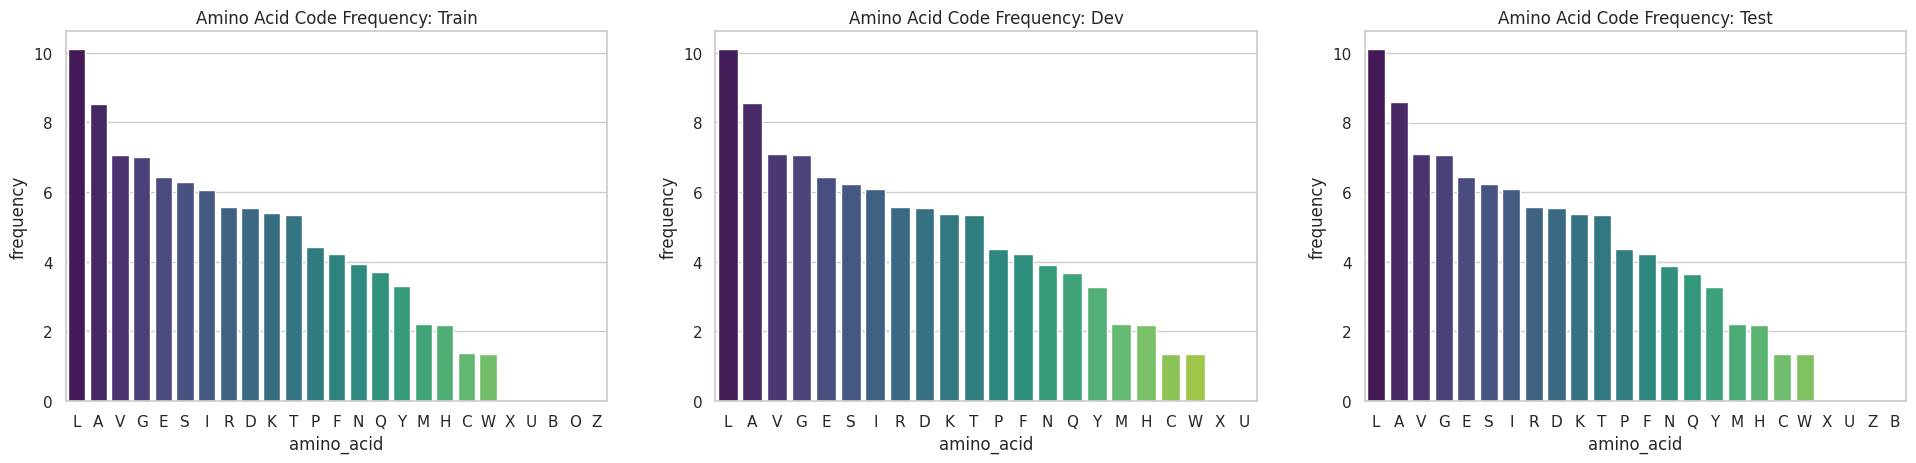

In [35]:
# Plot the frequency of amino acid codes in a given dataset.

plt.subplot(1, 3, 1)
plot_code_freq(train_amino_acid_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(dev_amino_acid_freq, 'Dev')

plt.subplot(1, 3, 3)
plot_code_freq(test_amino_acid_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.savefig('amino_acid_codes_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# How many sequences have rare amino acids like 'X', 'U', 'B', 'O', 'Z'

# Extract the sequences from the DataFrame
total_sequences = total_data_df['sequence']

# Count the occurrence of amino acids
amino_acids_counter = Counter()
for seq in total_sequences:
    amino_acids_counter.update(seq)

In [37]:
for rare_amino_acid in ['X', 'U', 'B', 'O', 'Z']:
    print(f'{rare_amino_acid}: {amino_acids_counter[rare_amino_acid]}')

X: 1849
U: 143
B: 35
O: 18
Z: 12


In [38]:
# Number of sequences containing the rare amino acids
count_seq_rare_amino_acids = {}

for seq in total_sequences:
    for rare_amino_acid in ['X', 'U', 'B', 'O', 'Z']:
        if rare_amino_acid in seq:
            count_seq_rare_amino_acids[rare_amino_acid] = 1 + count_seq_rare_amino_acids.get(rare_amino_acid, 0)

In [39]:
count_seq_rare_amino_acids

{'X': 842, 'U': 111, 'B': 21, 'Z': 4, 'O': 18}

### Class Imbalance



The number of samples per family in the training set ranges from 1 (i.e. a class with one training example) to 3637. This is a hint towards of the class imbalance that might (or might not) impact the classification model.

In [ ]:
get_partitions_info(partition_frames, partition_names)

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,train,1086741,17929,3637,1,4,2037,155.379971
1,dev,126171,13071,454,1,9,1971,154.222206
2,test,126171,13071,454,1,9,1937,154.166845


Find out protein families with most sequences (No. of observations)


In [ ]:
train_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [ ]:
dev_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [ ]:
test_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

Following are the plots of the most frequent family_ids and their counts


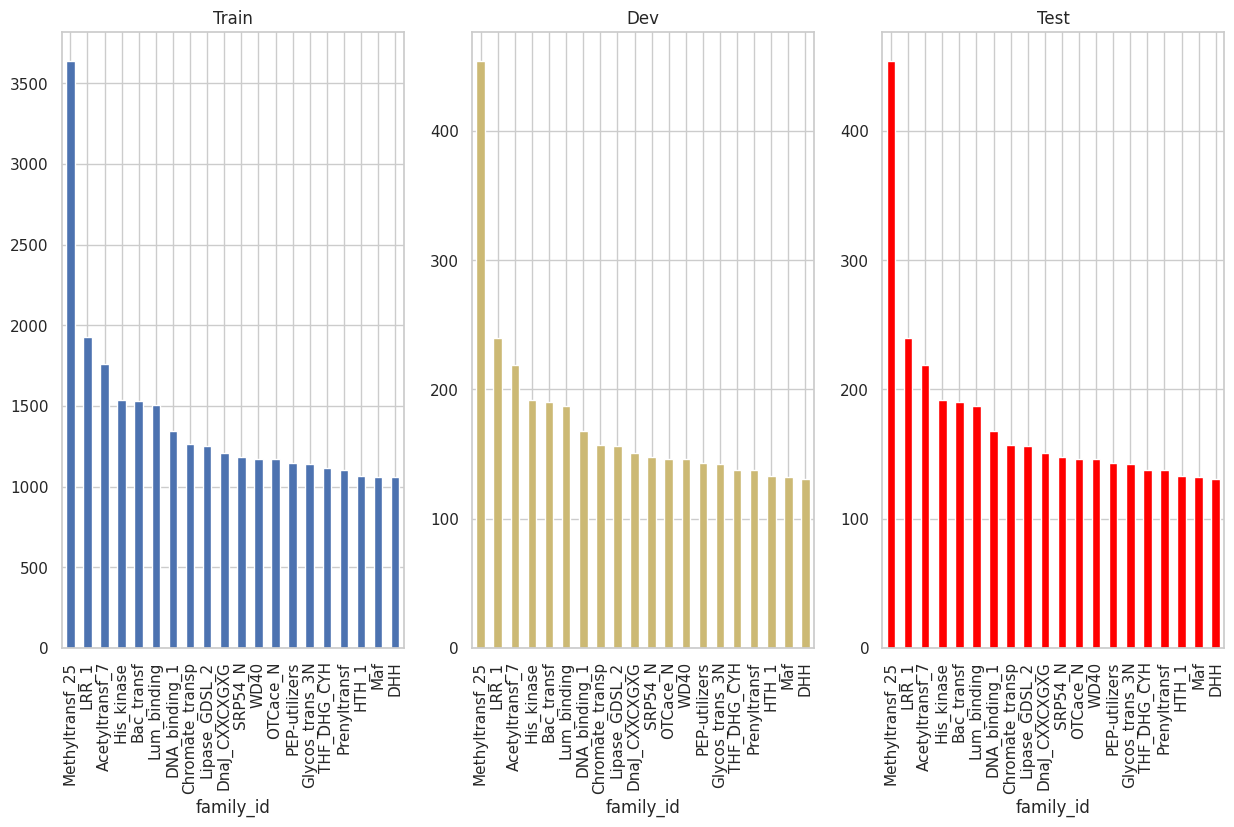

In [ ]:
print('Following are the plots of the most frequent family_ids and their counts')
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.title('Train')
train_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar')

plt.subplot(1,3,2)
plt.title('Dev')
dev_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='y')

plt.subplot(1,3,3)
plt.title('Test')
test_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='red')

plt.savefig('family_ids_TOP_popular.png', dpi=300, bbox_inches='tight')
plt.show()

**Observations**: Top 20 classes are same across all the sets train, test, dev. Test and Dev sets have almost same frequency for the top 20 classes.


Visualize the number of training samples per family from the most-represented to the least represented family. The y-axis denoting the number of samples is expressed in a logarithmic scale.  

The logarithmic scale is useful for plotting data that includes very small numbers and very large numbers because the scale plots the data so you can see all the numbers easily, without the small numbers squeezed too closely.

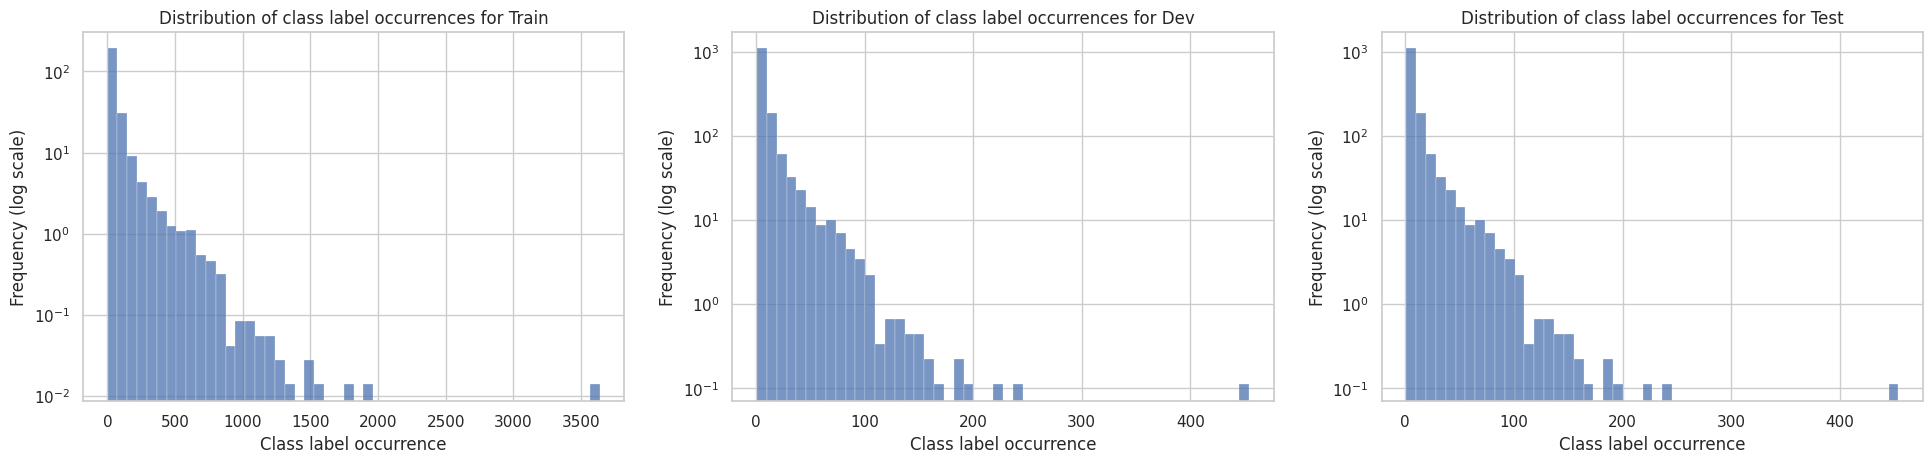

In [ ]:
plt.subplot(1, 3, 1)
plot_class_distribution_hist(train_df, split_name='Train', column_name='true_label')

plt.subplot(1, 3, 2)
plot_class_distribution_hist(dev_df, split_name='Dev', column_name='true_label')

plt.subplot(1, 3, 3)
plot_class_distribution_hist(test_df, split_name='Test', column_name='true_label')

plt.subplots_adjust(right=3.0)
plt.show()

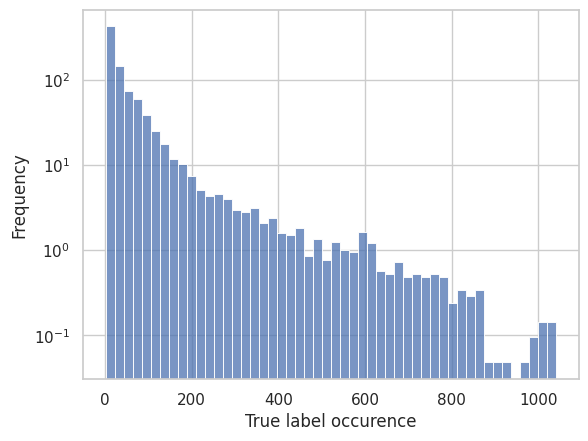

In [ ]:
true_label_counts = train_df.groupby('true_label').size()

# Skip N labels that are the most frequent
N = 20
true_label_counts_sorted = true_label_counts.sort_values(ascending=False)[N:]

plt.yscale('log')
sns.histplot(true_label_counts_sorted, stat='frequency', bins=50)
plt.xlabel('True label occurence')
plt.grid(True)

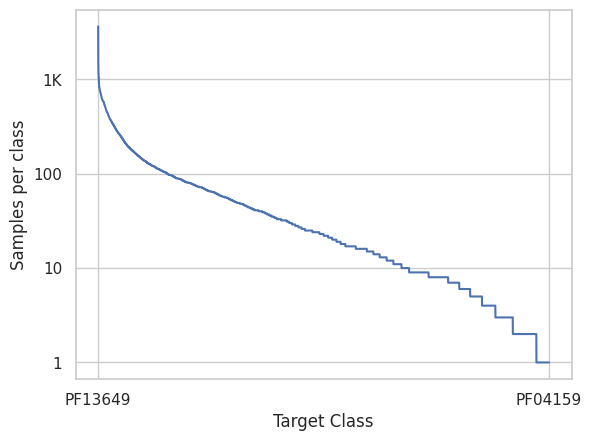

In [ ]:
plot_class_distribution_line(train_df, 'true_label')

**Observations**: 
- Most of the true_label (target variable) appear < 100 times, meaning there is a 'long-tail' of target labels.  

- There are some classes which appear even more than 500 times.  

- There is a class imbalance in a way that some labels dominant in occurrences. Potentially those occuring the most could be downsampled.

In [ ]:
train_df['family_id'].value_counts()

Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
                   ... 
Ery_res_leader1       1
UL20                  1
Thx                   1
Reo_P9                1
SARS_3b               1
Name: family_id, Length: 17929, dtype: int64

In [ ]:
# Check for class imbalance
print(train_df['family_id'].value_counts(normalize=True))

Methyltransf_25    3.346704e-03
LRR_1              1.773192e-03
Acetyltransf_7     1.620441e-03
His_kinase         1.414320e-03
Bac_transf         1.406039e-03
                       ...     
Ery_res_leader1    9.201825e-07
UL20               9.201825e-07
Thx                9.201825e-07
Reo_P9             9.201825e-07
SARS_3b            9.201825e-07
Name: family_id, Length: 17929, dtype: float64


Visualize the size of each family in terms of a percentage relative to the full size of the training set.

([<matplotlib.axis.XTick at 0x7f9a67d43eb0>,
 [Text(0, 0, 'PF13649'), Text(17929, 0, 'PF04159')])

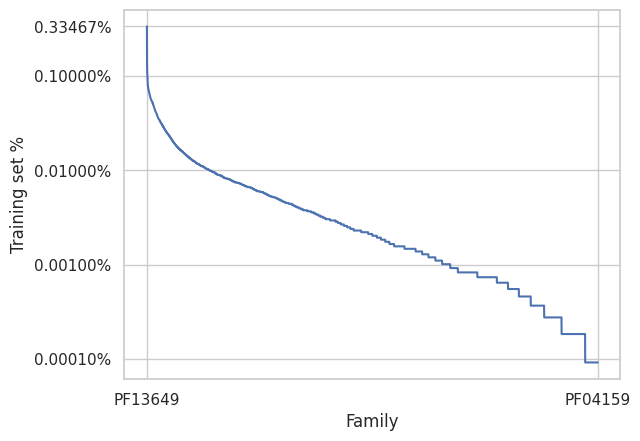

In [ ]:
train_classes = train_df.groupby('true_label').size().sort_values(ascending=False)
train_classes_occurs = train_classes.values

train_classes_occurs = 100 * train_classes_occurs / train_classes_occurs.sum()

plt.plot(train_classes_occurs)
plt.yscale('log')

ticks = list(10.**(-np.arange(1,5))) + [train_classes_occurs[0]]
labels = [f'{p:.5f}%' for p in ticks]
plt.yticks(
    ticks=ticks,
    labels=labels
)
plt.ylabel('Training set %')
plt.xlabel('Family')
plt.xticks(
    ticks=[0, train_classes_occurs.size],
    labels=[train_classes.index[0], train_classes.index[-1]]
)

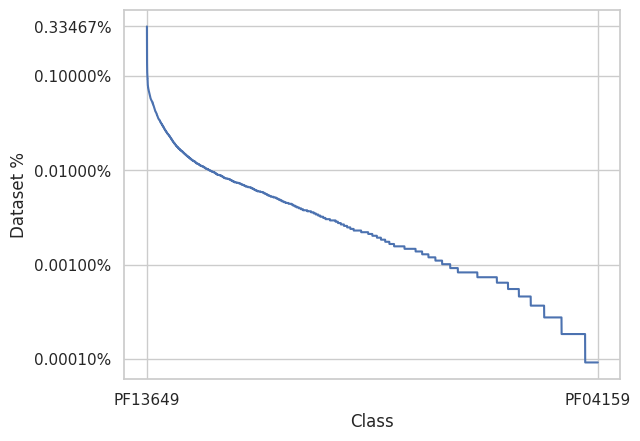

In [ ]:
plot_class_percentage_distribution_line(train_df, 'true_label')

**Observations**: 

- Even most dominant classes in the training dataset, make only a tiny fraction compared to the whole dataset. 
- The most-represented family makes only ~0.34% of the training set. 



---



---



## Practical considerations

**Note**: For the classification task in this project, only a subset of the available dataset will be used to predict the protein domain due to the computation resource limitations on Google Colab. Therefore, the size of the dataset needs to be reduced. 

However, in real-life settings, it is crucial to utilize all the available data.

## Filtering Dataset



### Keep only the true labels that are present in all 3 partitions

In [40]:
train_true_labels = set(train_df.true_label.unique())
dev_true_labels = set(dev_df.true_label.unique())    # labels in dev and test - overlap 

In [41]:
train_labels_extra = train_true_labels - dev_true_labels

In [42]:
train_df[train_df.true_label.isin(train_labels_extra)].groupby('true_label').size().sort_values(ascending=False)

true_label
PF00015    9
PF11822    9
PF04805    9
PF04837    9
PF17250    9
          ..
PF03569    1
PF10624    1
PF10653    1
PF10654    1
PF10379    1
Length: 4858, dtype: int64

Families exclusive to the training have at most 9 examples in this dataset. Total number of samples with classes present only in training set is 4858. Therefore, they can be ignored for the rest of this work.

In [43]:
train_df = train_df[~train_df.true_label.isin(train_labels_extra)]

In [44]:
len(train_df.true_label.unique())

13071

In [45]:
train_df.shape

(1064950, 8)

4858 samples were removed from the training dataset, since their target label is not present in dev/test sets.

In [46]:
get_partitions_info([train_df, dev_df, test_df], ['Train', 'Dev', 'Test'])

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,1064950,13071,3637,8,4,1972,154.774326
1,Dev,126171,13071,454,1,9,1971,154.222206
2,Test,126171,13071,454,1,9,1937,154.166845


### Only consider sequences with length in range [30 : 300]


Only consider sequences with lengths between 30 and 300 to accelerate experimentation.  

In [47]:
MIN_SEQ_LEN, MAX_SEQ_LEN = 30, 300

In [48]:
train_df = train_df[train_df.sequence_len.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]
dev_df = dev_df[dev_df.sequence_len.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]
test_df = test_df[test_df.sequence_len.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]

In [49]:
get_partitions_info([train_df, dev_df, test_df], ['Train', 'Dev', 'Test'])

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,931088,11585,3637,1,30,300,125.716726
1,Dev,110382,11398,454,1,30,300,125.534082
2,Test,110383,11403,454,1,30,300,125.392932


### Remove sequences with rare amino acids

In [50]:
rare_amino_acids = ['X', 'U', 'B', 'O', 'Z']

In [51]:
dev_df = dev_df[ ~ dev_df['sequence'].str.contains('|'.join(rare_amino_acids))]
test_df = test_df[ ~ test_df['sequence'].str.contains('|'.join(rare_amino_acids))]
train_df = train_df[ ~ train_df['sequence'].str.contains('|'.join(rare_amino_acids))]

In [52]:
get_partitions_info([train_df, dev_df, test_df], ['Train', 'Dev', 'Test'])

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,930503,11585,3637,1,30,300,125.708591
1,Dev,110311,11391,454,1,30,300,125.525025
2,Test,110305,11394,454,1,30,300,125.379665


In [60]:
# Sanity Check
total_sequences = pd.concat([dev_df, test_df, train_df], ignore_index=True)['sequence']

count_seq_rare_amino_acids = {}

for seq in total_sequences:
    for rare_amino_acid in rare_amino_acids:
        if rare_amino_acid in seq:
            count_seq_rare_amino_acids[rare_amino_acid] = 1 + count_seq_rare_amino_acids.get(rare_amino_acid, 0)

print(f'Num. of sequences containing rare amino acids: {len(count_seq_rare_amino_acids)}')

Num. of sequences containing rare amino acids: 0


In [62]:
# Get the frequency of each amino acid in the sequences of a given DataFrame
filtered_amino_acid_freq = get_amino_acid_freq(pd.concat([dev_df, test_df, train_df]), 'Total')

	##### Total
Total unique Amino Acids: 20


In [64]:
amino_acids_dict = {amino_acid: ind for ind, amino_acid in enumerate(filtered_amino_acid_freq['amino_acid'].unique(), start=1)}

In [65]:
assert len(amino_acids_dict) == len(filtered_amino_acid_freq)

In [68]:
amino_acids_dict['UNK'] = 0

In [69]:
# Get the mapping from Amino Acid to an integer for encoding purposes 
amino_acids_dict

{'L': 1,
 'A': 2,
 'V': 3,
 'G': 4,
 'E': 5,
 'I': 6,
 'S': 7,
 'R': 8,
 'D': 9,
 'K': 10,
 'T': 11,
 'P': 12,
 'F': 13,
 'N': 14,
 'Q': 15,
 'Y': 16,
 'M': 17,
 'H': 18,
 'C': 19,
 'W': 20,
 'UNK': 0}

### Consider only 10% of (original) target labels (most frequent ones)

To accelerate experimentation and compare different approaches with each other.

In [53]:
# Take 10% of the total number of classes existing in Pfam dataset
num_target_classes = int(0.1 * 17929)

num_target_classes

1792

In [54]:
most_freq_classes = set(
    (train_df.groupby('true_label').size()
                                   .sort_values(ascending=False)
                                   .head(num_target_classes)
                                   .keys())
)

In [55]:
assert len(most_freq_classes) == num_target_classes

In [56]:
train_df = train_df[train_df.true_label.isin(most_freq_classes)]
dev_df = dev_df[dev_df.true_label.isin(most_freq_classes)]
test_df = test_df[test_df.true_label.isin(most_freq_classes)]

In [57]:
get_partitions_info([train_df, dev_df, test_df], partition_names)

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,train,535321,1792,3637,127,30,300,121.757697
1,dev,65908,1792,454,14,30,300,121.778540
2,test,65884,1792,454,12,30,300,121.622230


In [58]:
## Sanity Check
# Are there overlaps between sets in 'true_label'?
overlapping_vals = compute_overlap(train_df, test_df, 'true_label')
print(f'Number of overlapping labels Train -- Test: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(train_df, dev_df, 'true_label')
print(f'Number of overlapping labels Train -- Dev: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(dev_df, test_df, 'true_label')
print(f'Number of overlapping labels Dev -- Test: {len(overlapping_vals)}')

Number of overlapping labels Train -- Test: 1792
Number of overlapping labels Train -- Dev: 1792
Number of overlapping labels Dev -- Test: 1792


### Add the encoded 'true_label' to datasets

In [59]:
from sklearn import preprocessing
from utils import save_label_encoder

In [39]:
# Get labels 
train_labels = train_df["true_label"].tolist()
test_labels = test_df["true_label"].tolist()
dev_labels = dev_df["true_label"].tolist()

all_labels = train_labels + test_labels + dev_labels

In [40]:
le = preprocessing.LabelEncoder()

In [41]:
le.fit(all_labels)

LabelEncoder()

In [42]:
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)
dev_labels = le.transform(dev_labels)

In [43]:
num_classes = len(list(le.classes_))
num_classes

1792

In [44]:
le.inverse_transform([0])

array(['PF00003'], dtype='<U7')

In [45]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(len(le_name_mapping))

1792


In [46]:
le_name_mapping['PF00003']

0

In [47]:
train_df["true_label_encoded"] = train_labels
test_df["true_label_encoded"] = test_labels
dev_df["true_label_encoded"] = dev_labels

In [48]:
# Save the LabelEncoder as a Dict
save_label_encoder(le, './')

0

In [49]:
# Save to Drive
# !mv ./label_encoder_mapping.json /content/drive/MyDrive/colabProteinProject/data/



---



---



In [51]:
# Save Filtered Datasets 
train_df.to_csv('/content/drive/MyDrive/colabProteinProject/data/train_filtered.csv', index=False)
dev_df.to_csv('/content/drive/MyDrive/colabProteinProject/data/dev_filtered.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/colabProteinProject/data/test_filtered.csv', index=False)